In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk

import yfinance as yf
import datetime




In [3]:
ticker='GARAN.IS'
start="2021-01-01"
end=str(datetime.date.today() +datetime.timedelta(days=1))
garan=yf.download(ticker,start,end)


[*********************100%***********************]  1 of 1 completed


In [4]:
garan

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,10.410000,10.510000,10.320000,10.33,9.201124,131841519
2021-01-05,10.290000,10.410000,10.050000,10.09,8.987351,200649427
2021-01-06,10.200000,10.440000,10.130000,10.40,9.263474,225358010
2021-01-07,10.530000,10.590000,10.390000,10.52,9.370360,162347598
2021-01-08,10.580000,10.810000,10.470000,10.79,9.610855,237594804
...,...,...,...,...,...,...
2023-06-14,28.860001,30.360001,28.700001,29.32,29.320000,109792126
2023-06-15,29.799999,30.760000,29.700001,30.66,30.660000,66227025
2023-06-16,30.879999,31.100000,30.059999,30.08,30.080000,64139443


In [5]:
close=pd.DataFrame(garan["Close"])

close


,Close
Date,
2021-01-04,10.33
2021-01-05,10.09
2021-01-06,10.40
2021-01-07,10.52
2021-01-08,10.79
...,...
2023-06-14,29.32
2023-06-15,30.66
2023-06-16,30.08


In [81]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=20).mean()
rolling_app21=close.rolling(window=50).mean()



In [82]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [83]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2021-03-12,8.92,9.014,9.2415,9.6948
2021-03-15,8.72,8.958,9.1750,9.6626
2021-03-16,8.86,8.926,9.1310,9.6380
2021-03-17,8.75,8.842,9.0910,9.6050
2021-03-18,9.04,8.858,9.0765,9.5754
...,...,...,...,...
2023-06-14,29.32,29.740,27.0650,27.7584
2023-06-15,30.66,29.876,27.2510,27.8144
2023-06-16,30.08,29.828,27.4400,27.8532


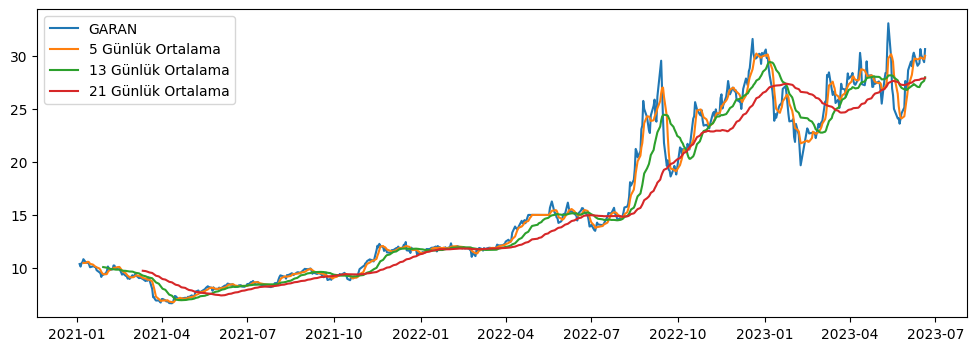

In [84]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='GARAN')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='13 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='21 Günlük Ortalama')
ax.legend(loc='upper left')


In [85]:
def buy_sell(data,perc=50):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    sm=np.abs(np.percentile(np.array(data["short"]-data["mid"]),perc))
    sl=np.abs(np.percentile(np.array(data["short"]-data["long"]),perc))

    for i in range(0,len(data)):
        if (data["short"][i]>data["mid"][i]+sm) & (data["short"][i]>data["long"][i]+sl):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
        elif (data["short"][i]<data["mid"][i]-sm)&(data["short"][i]<data["long"][i]-sl):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    operations=operations[neg:-pos]
    PL=np.sum(operations)

    return (buy_signal,sell_signal,PL)


In [86]:
m=buy_sell(MAs)
MAs["Al"]=m[0]
MAs["Sat"]=m[1]

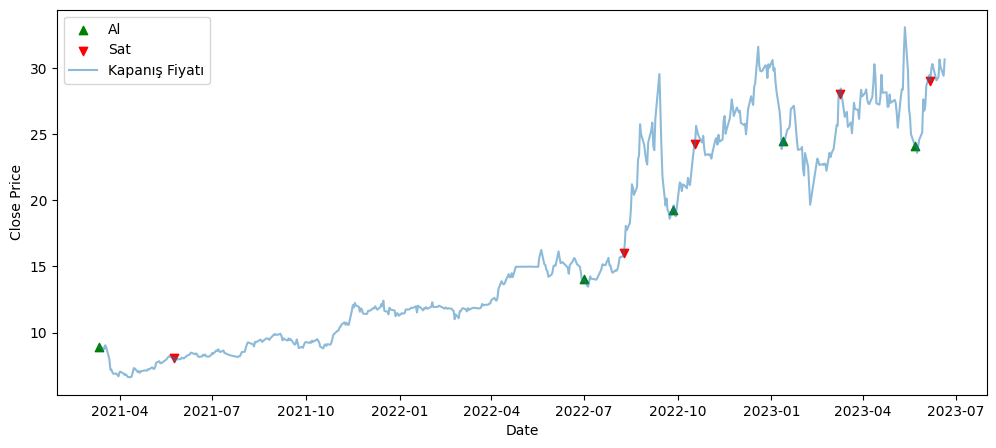

In [87]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Al"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sat"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [88]:
al=MAs["Al"]
al=al.dropna(axis=0)
al

Date
2021-03-12     8.92
2022-07-01    14.03
2022-09-26    19.27
2023-01-12    24.52
2023-05-22    24.10
Name: Al, dtype: float64

In [89]:
sat=MAs["Sat"]
sat=sat.dropna(axis=0)
sat


Date
2021-05-24     8.080000
2022-08-09    16.030001
2022-10-18    24.299999
2023-03-09    28.040001
2023-06-06    29.040001
Name: Sat, dtype: float64

In [90]:
sat_val=sat.values
al_val=al.values


In [91]:
sat_val1=sat_val

In [92]:
sat_val1

array([ 8.07999992, 16.03000069, 24.29999924, 28.04000092, 29.04000092])

In [93]:
al_val1=al_val
al_val1

array([ 8.92000008, 14.02999973, 19.27000046, 24.52000046, 24.10000038])

In [94]:
res=[]

for i in range(len(al_val1)):
    res.append((sat_val1[i]/al_val1[i]))

In [95]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,0.905830
1,1.142552
2,1.261027
3,1.143556
4,1.204979


In [96]:
res0=[100]
for i in range(5):
    res0.append(res0[i]*df["Kar"].loc[i])


In [97]:
df["Eldeki Para"]=res0[1:]
df

,Kar,Eldeki Para
0,0.905830,90.582958
1,1.142552,103.495717
2,1.261027,130.510938
3,1.143556,149.246605
4,1.204979,179.839066


In [98]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 79.83906566339066


## Her sat tavsiyesinde satmayıp 2.sat tavsiyesinde satarsak ne olur?(Yani 1 adet sat tavsiyesini pas geçersek)

In [99]:
sat_val2=sat_val[1:5:2]

In [100]:
sat_val2

array([16.03000069, 28.04000092])

In [101]:
al_val2=al_val[0:4:2]
al_val2

array([ 8.92000008, 19.27000046])

In [102]:
res1=[]

for i in range(2):
    res1.append((sat_val2[i]/al_val2[i]))

In [103]:
df1=pd.DataFrame()
df1["Kar"]=res1
df1

,Kar
0,1.797085
1,1.455112


In [104]:
res2=[100]
for i in range(2):
    res2.append(res2[i]*df1["Kar"].loc[i])




In [105]:
df1["Eldeki Para"]=res2[1:]
df1


,Kar,Eldeki Para
0,1.797085,179.708526
1,1.455112,261.495959


In [106]:
karlilik=df1["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 161.49595866122
